In [13]:
from RNN_model import lr_RNN, Net, PLRNN, PlainRNN
import torch
import numpy as np

from run_model import (
    build_loaders, build_model,
    EarlyStopping, train_model, train_model_new, evaluate_model,
    reg_l1_weight, reg_l2_weight, reg_tv, reg_smooth,
    make_reg_spectral)

In [14]:
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
train_data =np.load("./demo_data/train_data.npy") 
test_data = np.load("./demo_data/test_data.npy")

In [16]:
seq_len_total = 375
stride = 375
batch_size = 8  
seed = 42

train_loader, val_loader, test_loader = build_loaders(
    train_data=train_data, 
    test_data=test_data,    
    seq_len_total=seq_len_total,
    stride=stride,
    batch_size=batch_size,
    seed=seed
)


In [23]:
dim_x      = train_data.shape[1]
lr         = 1e-3
num_epochs = 200  
dim_z      = 256  
tau        = 5    

In [24]:
model_type = 'RNN'
# model_type = 'lrRNN'
# model_type = 'EIRNN'
# model_type = 'dendPLRNN'

model = build_model(model_type, dim_x, dim_z, tau, device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, threshold=1e-5, min_lr=1e-8)
early_stop = EarlyStopping(patience=10, min_delta=1e-5)
criterion  = torch.nn.MSELoss() 
regularizers = {}

save_path = f'./demo_result/{model_type}_tau{tau}_hidden{dim_z}.pth'


In [25]:
_, history=train_model_new(model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            early_stop=early_stop,
            num_epochs=num_epochs,
            save_path=save_path,
            regularizers=regularizers,
            device=device,
            dim_z=dim_z,
            tau=tau,
            model_type=model_type
        )

Epoch 000: train=0.004235, val=0.002220, lr=0.001
  ↳ New best val loss: 0.002220
Epoch 001: train=0.001420, val=0.001584, lr=0.001
  ↳ New best val loss: 0.001584
Epoch 002: train=0.001055, val=0.001373, lr=0.001
  ↳ New best val loss: 0.001373
Epoch 003: train=0.000972, val=0.001313, lr=0.001
  ↳ New best val loss: 0.001313
Epoch 004: train=0.000921, val=0.001250, lr=0.001
  ↳ New best val loss: 0.001250
Epoch 005: train=0.000878, val=0.001199, lr=0.001
  ↳ New best val loss: 0.001199
Epoch 006: train=0.000841, val=0.001159, lr=0.001
  ↳ New best val loss: 0.001159
Epoch 007: train=0.000841, val=0.001155, lr=0.001
  ↳ No improvement (1/10)
Epoch 008: train=0.000814, val=0.001096, lr=0.001
  ↳ New best val loss: 0.001096
Epoch 009: train=0.000782, val=0.001062, lr=0.001
  ↳ New best val loss: 0.001062
Epoch 010: train=0.000763, val=0.001039, lr=0.001
  ↳ New best val loss: 0.001039
Epoch 011: train=0.000754, val=0.001029, lr=0.001
  ↳ No improvement (1/10)
Epoch 012: train=0.000742, v

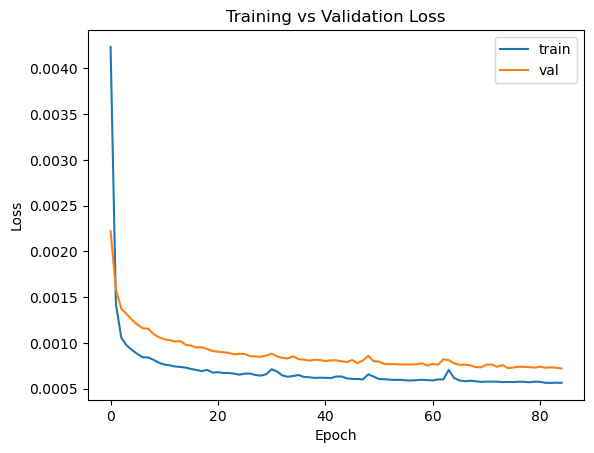

In [26]:
import matplotlib.pyplot as plt
ckpt = torch.load(save_path, map_location=device)
history = ckpt.get("history", None)
plt.figure()
plt.plot(history["epoch"], history["train_loss"], label="train")
plt.plot(history["epoch"], history["val_loss"],   label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


Evaluating each epoch: 100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


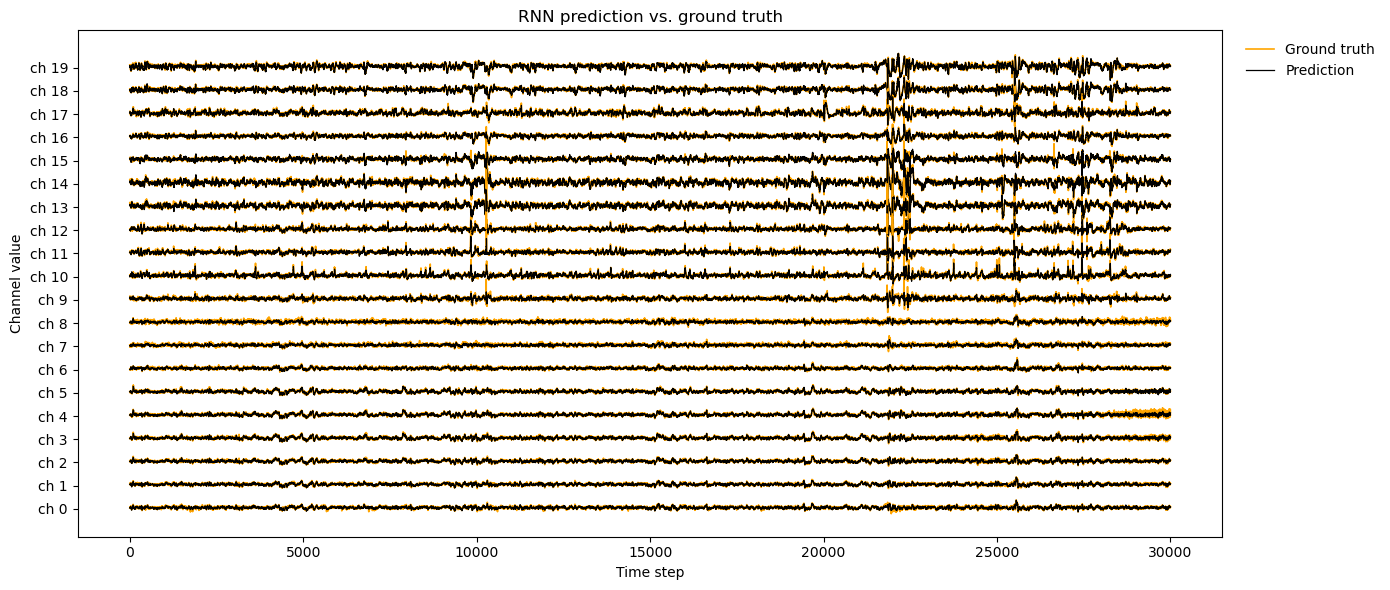

In [27]:
eval_df = evaluate_model(model, test_loader, save_path,
                        tau=tau,
                        device=device,
                        model_type=model_type,
                        reg_tag="",
                        dim_z=dim_z,
                        metrics=["MSE","MAE","EV","R2","spec_sim","KL","Hellinger","FC_SIM"])


In [28]:
print(eval_df.mean())

MSE          0.000266
MAE          0.011811
EV           0.691125
R2           0.676009
spec_sim     0.990170
KL           0.308765
Hellinger    0.134658
FC_SIM       0.738517
dtype: float64
